## MNIST Synthetic Dataset

In [1]:
import gzip
import numpy as np
import os
import h5py
import sys
import tarfile
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [2]:
URL = 'http://yann.lecun.com/exdb/mnist/'
LAST_PERCENT_REPORTED = None
DATA_ROOT = '.' # Change me to store data elsewhere

IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255.0

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global LAST_PERCENT_REPORTED
    percent = int(count * blockSize * 100 / totalSize)

    if LAST_PERCENT_REPORTED != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
        LAST_PERCENT_REPORTED = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(DATA_ROOT, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(URL + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?'
        )
    return dest_filename

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
        return data

def extract_labels(filename, num_images):
    """Extract the labels into a vector of int64 label IDs."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

mnist_train_image_file = maybe_download('train-images-idx3-ubyte.gz', 9912422)
mnist_train_label_file = maybe_download('train-labels-idx1-ubyte.gz', 28881)
mnist_test_image_file = maybe_download('t10k-images-idx3-ubyte.gz', 1648877)
mnist_test_label_file = maybe_download('t10k-labels-idx1-ubyte.gz', 4542)

mnist_train_data = extract_data(mnist_train_image_file, 60000)
mnist_train_labels = extract_labels(mnist_train_label_file, 60000)
mnist_test_data = extract_data(mnist_test_image_file, 10000)
mnist_test_labels = extract_labels(mnist_test_label_file, 10000)

mnist_valid_data = mnist_test_data[:5000, :, :, :]
mnist_test_data = mnist_test_data[5000:, :, :, :]

mnist_valid_labels = mnist_test_labels[:5000]
mnist_test_labels = mnist_test_labels[5000:]

Found and verified ./train-images-idx3-ubyte.gz
Found and verified ./train-labels-idx1-ubyte.gz
Found and verified ./t10k-images-idx3-ubyte.gz
Found and verified ./t10k-labels-idx1-ubyte.gz
Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [3]:
MAX_DIGITS = 5
NUM_LABELS = 11 # 0-9 plus blank image
BLANK_IMAGE = (np.zeros((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)) - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

def generate_multiple_digit_data(data, labels, count, max_digits=MAX_DIGITS):    
    buffer_data = data
    buffer_labels = labels    
    multiple_digit_data = np.empty((count, IMAGE_SIZE, IMAGE_SIZE * max_digits, NUM_CHANNELS), dtype=np.float32)
    multiple_digit_labels = np.empty((count, MAX_DIGITS + 1, NUM_LABELS), dtype=np.float32)
    
    for idx in range(count):                    
        num_digits = random.randint(1, max_digits)
        num_zeros = max_digits - num_digits
        one_hot = np.zeros((MAX_DIGITS + 1, NUM_LABELS), dtype=np.float32)
        
        if num_digits > len(buffer_labels):           
            data, labels = randomize(data, labels)
            buffer_data = np.concatenate((buffer_data, data), axis=0)
            buffer_labels = np.concatenate((buffer_labels, labels))
    
        d, l = buffer_data[:num_digits, :, :, :], buffer_labels[:num_digits]
        buffer_data, buffer_labels = buffer_data[num_digits:, :, :, :], buffer_labels[num_digits:]

        if num_zeros:
            d = np.concatenate((d, [BLANK_IMAGE] * num_zeros), axis=0)
            l = np.concatenate((l, [10] * num_zeros))

        d = d.swapaxes(0, 1).reshape(IMAGE_SIZE, IMAGE_SIZE * max_digits, NUM_CHANNELS)
        l = np.concatenate((l, [num_digits]))
        
        one_hot[np.arange(l.shape[0]), l] = 1

        multiple_digit_data[idx] = d
        multiple_digit_labels[idx] = one_hot
        
    return multiple_digit_data, multiple_digit_labels

In [4]:
train_dataset, train_labels = generate_multiple_digit_data(mnist_train_data, mnist_train_labels, count=180000)
valid_dataset, valid_labels = generate_multiple_digit_data(mnist_valid_data, mnist_valid_labels, count=10000)
test_dataset, test_labels = generate_multiple_digit_data(mnist_test_data, mnist_test_labels, count=10000)

In [5]:
del mnist_train_data
del mnist_train_labels
del mnist_valid_data
del mnist_valid_labels
del mnist_test_data
del mnist_test_labels

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


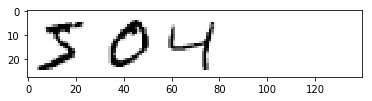

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


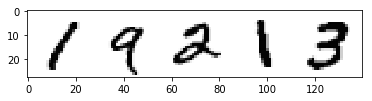

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


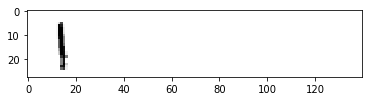

[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


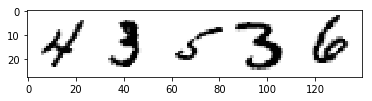

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


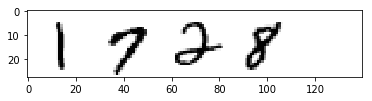

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


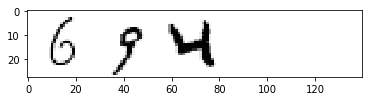

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


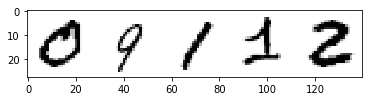

[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


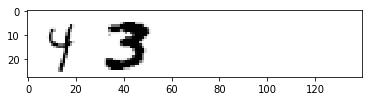

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


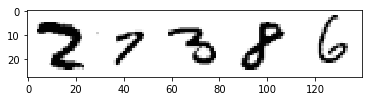

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


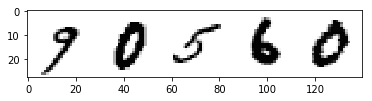

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


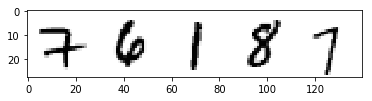

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


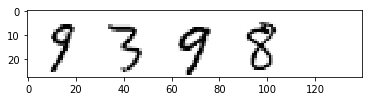

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


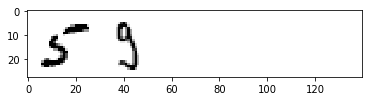

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


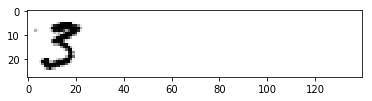

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


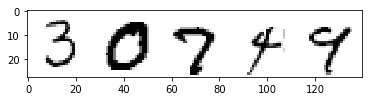

[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


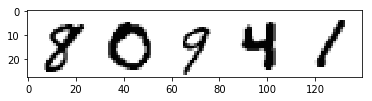

[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


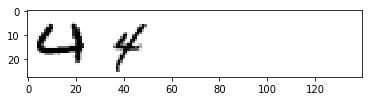

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


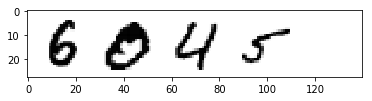

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


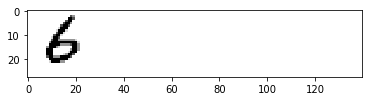

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


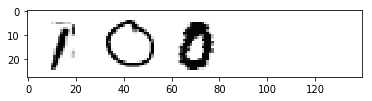

In [6]:
for idx in range(20):
    print(train_labels[idx])
    plt.imshow(train_dataset[idx, :, :, 0], cmap=plt.cm.Greys)
    plt.show()

In [7]:
def reshape(labels):
    shape = labels.shape
    return labels.swapaxes(0, 1).reshape((shape[0] * shape[1], shape[2]))

def accuracy(predictions, labels):
    digitized_predictions = np.split(predictions, MAX_DIGITS)
    digitized_labels = np.split(labels, MAX_DIGITS + 1)[:-1]
    digit_acc = []
    acc = np.zeros((digitized_predictions[0].shape[0], ))
    for i, (p, l) in enumerate(zip(digitized_predictions, digitized_labels)):
        digit_acc.append(100.0 * np.sum(np.argmax(p, axis=1) == np.argmax(l, axis=1)) / p.shape[0])
        if i < MAX_DIGITS:
            correct = np.argmax(p, axis=1) == np.argmax(l, axis=1)
            acc = np.add(acc, correct)
    
    overall_acc = 100 * np.sum(acc / MAX_DIGITS) / acc.shape[0]
    return digit_acc, overall_acc

def format_accuracy(accuracy):
    return ['%.1f%%' % a for a in accuracy]

In [8]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH = 16

IMAGE_LENGTH = IMAGE_SIZE * MAX_DIGITS

STRIDE = 1
POOL_STRIDE = 2
POOL_KERNEL_SIZE = 2

NUM_HIDDEN = 256

NUM_STEPS = 3001

graph = tf.Graph()

with graph.as_default():
    
    tf_train_dataset = tf.placeholder(
        dtype=tf.float32,
        shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_LENGTH, NUM_CHANNELS)
    )
    
    tf_train_labels = tf.placeholder(
        dtype=tf.float32,
        shape=(BATCH_SIZE * (MAX_DIGITS + 1), NUM_LABELS)
    )
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    loss_weights = tf.constant([10, 10, 5, 1, 1], dtype=tf.float32)
    
    keep_prob = tf.placeholder(dtype=tf.float32)
    
    global_step = tf.Variable(0, trainable=False)
    initial_learning_rate = 0.05
    learning_rate = tf.train.exponential_decay(
        learning_rate=initial_learning_rate,
        global_step=global_step,
        decay_steps=50,
        decay_rate=0.96,
        staircase=True
    )
    
    l01_weights = tf.Variable(tf.truncated_normal(
        [PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH],
        stddev=0.1
    ))
    l01_biases = tf.Variable(tf.zeros([DEPTH]))
    
    l02_weights = tf.Variable(tf.truncated_normal(
        [PATCH_SIZE, PATCH_SIZE, DEPTH, DEPTH],
        stddev=0.1
    ))
    l02_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH]))
    '''
    li01_1_1x1_weights = tf.Variable(tf.truncated_normal(
        [1, 1, 16, 8],
        stddev=0.1
    ))
    li01_1_1x1_biases = tf.Variable(tf.constant(1.0, shape=[8]))
    
    li01_2_1x1_weights = tf.Variable(tf.truncated_normal(
        [1, 1, 16, 8],
        stddev=0.1
    ))
    li01_2_1x1_biases = tf.Variable(tf.constant(1.0, shape=[8]))

    li01_2_3x3_weights = tf.Variable(tf.truncated_normal(
        [3, 3, 8, 16],
        stddev=0.1
    ))
    li01_2_3x3_biases = tf.Variable(tf.constant(1.0, shape=[16]))
    
    li01_3_1x1_weights = tf.Variable(tf.truncated_normal(
        [1, 1, 16, 8],
        stddev=0.1
    ))
    li01_3_1x1_biases = tf.Variable(tf.constant(1.0, shape=[8]))

    li01_3_5x5_weights = tf.Variable(tf.truncated_normal(
        [5, 5, 8, 16],
        stddev=0.1
    ))
    li01_3_5x5_biases = tf.Variable(tf.constant(1.0, shape=[16]))

    li01_4_1x1_weights = tf.Variable(tf.truncated_normal(
        [1, 1, 16, 16],
        stddev=0.1
    ))
    li01_4_1x1_biases = tf.Variable(tf.constant(1.0, shape=[16]))
    '''
    
    l03_weights = tf.Variable(tf.truncated_normal(
        [IMAGE_SIZE // 4 * IMAGE_LENGTH // 4 * 16, NUM_HIDDEN],
        stddev=0.1
    ))
    l03_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]))
    
    lc_d1_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_d1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    lc_d2_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_d2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    lc_d3_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_d3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    lc_d4_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_d4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    lc_d5_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_d5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    lc_length_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_length_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    def model(data):
        
        conv = tf.nn.conv2d(
            input=data,
            filter=l01_weights,
            strides=[1, STRIDE, STRIDE, 1],
            padding='SAME'
        )
        hidden = tf.nn.relu(conv + l01_biases)
        pool = tf.nn.max_pool(
            value=hidden,
            ksize=[1, POOL_KERNEL_SIZE, POOL_KERNEL_SIZE, 1],
            strides=[1, POOL_STRIDE, POOL_STRIDE, 1],
            padding='VALID'
        )
        
        conv = tf.nn.conv2d(
            input=pool,
            filter=l02_weights,
            strides=[1, STRIDE, STRIDE, 1],
            padding='SAME'
        )
        hidden = tf.nn.relu(conv + l02_biases)
        pool = tf.nn.max_pool(
            value=hidden,
            ksize=[1, POOL_KERNEL_SIZE, POOL_KERNEL_SIZE, 1],
            strides=[1, POOL_STRIDE, POOL_STRIDE, 1],
            padding='VALID'
        )
        
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden = tf.nn.relu(tf.matmul(reshape, l03_weights) + l03_biases)
        dropout = tf.nn.dropout(hidden, keep_prob)
        return (
            tf.matmul(dropout, lc_d1_weights) + lc_d1_biases,
            tf.matmul(dropout, lc_d2_weights) + lc_d2_biases,
            tf.matmul(dropout, lc_d3_weights) + lc_d3_biases,
            tf.matmul(dropout, lc_d4_weights) + lc_d4_biases,
            tf.matmul(dropout, lc_d5_weights) + lc_d5_biases
        )
    
    logits_d1, logits_d2, logits_d3, logits_d4, logits_d5 = model(tf_train_dataset)
        
    labels_d1, labels_d2, labels_d3, labels_d4, labels_d5, _ = tf.split(
        tf_train_labels,
        num_or_size_splits=6,
        axis=0
    )
    
    loss_d1 = tf.nn.softmax_cross_entropy_with_logits(labels=labels_d1, logits=logits_d1)
    loss_d2 = tf.nn.softmax_cross_entropy_with_logits(labels=labels_d2, logits=logits_d2)
    loss_d3 = tf.nn.softmax_cross_entropy_with_logits(labels=labels_d3, logits=logits_d3)
    loss_d4 = tf.nn.softmax_cross_entropy_with_logits(labels=labels_d4, logits=logits_d4)
    loss_d5 = tf.nn.softmax_cross_entropy_with_logits(labels=labels_d5, logits=logits_d5)
 
    loss = tf.reduce_sum(loss_weights * tf.stack(
        (
            tf.reduce_mean(loss_d1),
            tf.reduce_mean(loss_d2),
            tf.reduce_mean(loss_d3),
            tf.reduce_mean(loss_d4),
            tf.reduce_mean(loss_d5)
        ),
        axis=0
    )) / tf.reduce_sum(loss_weights)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    train_prediction = tf.concat(
        (
            tf.nn.softmax(logits_d1),
            tf.nn.softmax(logits_d2),
            tf.nn.softmax(logits_d3),
            tf.nn.softmax(logits_d4),
            tf.nn.softmax(logits_d5)
        ),
        axis=0
    )
    
    v_logits_d1, v_logits_d2, v_logits_d3, v_logits_d4, v_logits_d5 = model(tf_valid_dataset)
    valid_prediction = tf.concat(
        (
            tf.nn.softmax(v_logits_d1),
            tf.nn.softmax(v_logits_d2),
            tf.nn.softmax(v_logits_d3),
            tf.nn.softmax(v_logits_d4),
            tf.nn.softmax(v_logits_d5)
        ),
        axis=0
    )
    
    t_logits_d1, t_logits_d2, t_logits_d3, t_logits_d4, t_logits_d5 = model(tf_test_dataset)
    test_prediction = tf.concat(
        (
            tf.nn.softmax(t_logits_d1),
            tf.nn.softmax(t_logits_d2),
            tf.nn.softmax(t_logits_d3),
            tf.nn.softmax(t_logits_d4),
            tf.nn.softmax(t_logits_d5)
        ),
        axis=0
    )
    
with tf.Session(graph=graph) as session:
    
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(NUM_STEPS):
        
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset+BATCH_SIZE), :, :, :]
        batch_labels = reshape(train_labels[offset:(offset+BATCH_SIZE), :, :])
        
        feed_dict = {
            tf_train_dataset: batch_data,
            tf_train_labels: batch_labels,
            keep_prob: 0.5
        }
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 100 == 0):
            train_accuracies = accuracy(predictions, batch_labels)
            valid_accuracies = accuracy(valid_prediction.eval({keep_prob: 1.0}), reshape(valid_labels))
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracies: %s / Overall accuracy: %.1f%%' % (format_accuracy(train_accuracies[0]), train_accuracies[1]))
            print('Validation accuracies: %s / Overall accuracy: %.1f%%' % (format_accuracy(valid_accuracies[0]), valid_accuracies[1]))
            
    test_accuracies = accuracy(test_prediction.eval({keep_prob: 1.0}), reshape(test_labels))
    print('Test accuracies: %s / Overall accuracy: %.1f%%' % (format_accuracy(test_accuracies[0]), test_accuracies[1]))
    
    

Initialized
Minibatch loss at step 0: 17.436087
Minibatch accuracies: ['3.1%', '9.4%', '6.2%', '10.9%', '7.8%'] / Overall accuracy: 7.5%
Validation accuracies: ['11.3%', '5.7%', '40.3%', '8.5%', '79.7%'] / Overall accuracy: 29.1%
Minibatch loss at step 100: 1.935504
Minibatch accuracies: ['25.0%', '31.2%', '39.1%', '64.1%', '78.1%'] / Overall accuracy: 47.5%
Validation accuracies: ['42.7%', '40.8%', '44.6%', '60.4%', '79.7%'] / Overall accuracy: 53.6%
Minibatch loss at step 200: 1.530247
Minibatch accuracies: ['35.9%', '56.2%', '59.4%', '54.7%', '81.2%'] / Overall accuracy: 57.5%
Validation accuracies: ['64.9%', '62.8%', '54.5%', '60.9%', '79.7%'] / Overall accuracy: 64.6%
Minibatch loss at step 300: 1.128097
Minibatch accuracies: ['70.3%', '54.7%', '59.4%', '64.1%', '82.8%'] / Overall accuracy: 66.3%
Validation accuracies: ['74.0%', '73.2%', '62.4%', '62.0%', '79.7%'] / Overall accuracy: 70.2%
Minibatch loss at step 400: 0.981605
Minibatch accuracies: ['70.3%', '67.2%', '62.5%', '62.5

## SVHN Dataset

In [9]:
URL = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall('.')
        tar.close()
    return root

svhn_train_tarfile = maybe_download('train.tar.gz', 404141560)
svhn_test_tarfile = maybe_download('test.tar.gz', 276555967)
svhn_extra_tarfile = maybe_download('extra.tar.gz', 1955489752)

svhn_train_folder = maybe_extract(svhn_train_tarfile)
svhn_test_folder = maybe_extract(svhn_test_tarfile)
svhn_extra_folder = maybe_extract(svhn_extra_tarfile)

Found and verified ./train.tar.gz
Found and verified ./test.tar.gz
Found and verified ./extra.tar.gz
./train already present - Skipping extraction of ./train.tar.gz.
./test already present - Skipping extraction of ./test.tar.gz.
./extra already present - Skipping extraction of ./extra.tar.gz.


In [10]:
CWD = os.getcwd()
METAFILE = 'digitStruct.mat'

def maybe_pickle_metadata(folder, pickle_name, force=False):
    pickle_path = os.path.join(CWD, pickle_name)
    
    if not os.path.isfile(pickle_path) or force:
        
        metapath = os.path.join(folder, METAFILE)

        metadata= {}
        metadata['height'] = []
        metadata['label'] = []
        metadata['left'] = []
        metadata['top'] = []
        metadata['width'] = []

        f = h5py.File(metapath)
        def print_attrs(name, obj):
            vals = []
            if obj.shape[0] == 1:
                vals.append(int(obj[0][0]))
            else:
                for k in range(obj.shape[0]):
                    vals.append(int(f[obj[k][0]][0][0]))
            metadata[name].append(vals)

        for item in f['/digitStruct/bbox']:
            f[item[0]].visititems(print_attrs)

        with open(pickle_path,'wb') as pf:
            pickle.dump(metadata, pf, pickle.HIGHEST_PROTOCOL) 
            
    else:
        print('%s already present - Skipping pickle.' % pickle_path)
    
    return pickle_path

In [11]:
train_metadata = maybe_pickle_metadata(svhn_train_folder, 'train_metadata.pickle')
test_metadata = maybe_pickle_metadata(svhn_test_folder, 'test_metadata.pickle')
extra_metadata = maybe_pickle_metadata(svhn_extra_folder, 'extra_metadata.pickle')

/Users/yth/apps/101/udacity_deep_learning/train_metadata.pickle already present - Skipping pickle.
/Users/yth/apps/101/udacity_deep_learning/test_metadata.pickle already present - Skipping pickle.
/Users/yth/apps/101/udacity_deep_learning/extra_metadata.pickle already present - Skipping pickle.


In [12]:
with open(train_metadata, "rb") as f:
    metadata = pickle.load(f)
    label_lengths = np.array([len(l) for l in metadata['label']])
    print(np.sum(label_lengths > 5))
    print(np.where(label_lengths > 5))
    # 29930.png has 6 digits, skip it when generating dataset and labels

1
(array([29929]),)


In [13]:
IMAGE_SIZE = 32

def maybe_generate(folder, metadata, pickle_name, skips, force=False):
    pickle_path = os.path.join(CWD, pickle_name)
    if not os.path.isfile(pickle_path) or force:
        with open(metadata, "rb") as f:
            metadata = pickle.load(f)
            num_samples = len(metadata['label']) - len(skips)
            images = np.zeros((num_samples, IMAGE_SIZE, IMAGE_SIZE, 1), dtype=np.float32)
            labels = np.zeros((num_samples, MAX_DIGITS + 1, NUM_LABELS), dtype=np.float32)    

            for idx in range(num_samples):
                if idx not in skips:

                    # image files
                    image_file = os.path.join(folder, str(idx + 1) + '.png')
                    try:
                        image = ndimage.imread(image_file).astype(np.float32)
                        # convert to greyscale
                        grey = np.dot(image, [0.299, 0.587, 0.114])
                    except IOError as e:
                        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

                    tops = np.array(metadata['top'][idx])
                    lefts = np.array(metadata['left'][idx])
                    heights = np.array(metadata['height'][idx])
                    widths = np.array(metadata['width'][idx])

                    bottoms = np.add(tops, heights)
                    rights = np.add(lefts, widths)

                    top = max(tops.min(), 0)
                    left = max(lefts.min(), 0)
                    bottom = min(bottoms.max(), grey.shape[0])
                    right = min(rights.max(), grey.shape[1])

                    # cropped, squared, resized
                    cropped = grey[top:bottom, left:right]
                    # max_shape = max(cropped.shape)
                    # squared = np.zeros((max_shape, max_shape), dtype=np.float32)
                    # squared[:bottom-top, :right-left] = cropped
                    resized = imresize(cropped, (IMAGE_SIZE, IMAGE_SIZE))

                    # normalized
                    normalized = (resized - PIXEL_DEPTH / 2) / PIXEL_DEPTH
                    normalized = normalized.reshape((IMAGE_SIZE, IMAGE_SIZE, 1))

                    images[idx] = normalized

                    # labels
                    l = np.array(metadata['label'][idx])
                    l[l == 10] = 0
                    num_digits = l.shape[0]
                    num_zeros = MAX_DIGITS - num_digits
                    one_hot = np.zeros((MAX_DIGITS + 1, NUM_LABELS), dtype=np.float32)

                    if num_zeros:
                        l = np.concatenate((l, [10] * num_zeros))

                    l = np.concatenate((l, [num_digits]))
                    one_hot[np.arange(l.shape[0]), l] = 1

                    labels[idx] = one_hot
            
            with open(pickle_path,'wb') as pf:
                pickle.dump([images, labels], pf, pickle.HIGHEST_PROTOCOL) 
    else:
        print('%s already present - Skipping pickle.' % pickle_path)
    
    return pickle_path

In [14]:
train_picklefile = maybe_generate(
    svhn_train_folder,
    train_metadata,
    pickle_name='train.pickle',
    skips=[29929]
)
test_picklefile = maybe_generate(
    svhn_test_folder,
    test_metadata,
    pickle_name='test.pickle',
    skips=[]
)
extra_picklefile = maybe_generate(
    svhn_extra_folder,
    extra_metadata,
    pickle_name='extra.pickle',
    skips=[]
)

/Users/yth/apps/101/udacity_deep_learning/train.pickle already present - Skipping pickle.
/Users/yth/apps/101/udacity_deep_learning/test.pickle already present - Skipping pickle.
/Users/yth/apps/101/udacity_deep_learning/extra.pickle already present - Skipping pickle.


In [15]:
with open(train_picklefile, "rb") as f_train, open(test_picklefile, 'rb') as f_test, open(extra_picklefile, 'rb') as f_extra:
    train_dataset, train_labels = pickle.load(f_train)
    test_dataset, test_labels = pickle.load(f_test)
    extra_dataset, extra_labels = pickle.load(f_extra)

    train_dataset = np.concatenate((train_dataset, extra_dataset), axis=0)
    train_labels = np.concatenate((train_labels, extra_labels), axis=0)

    train_dataset, valid_dataset = np.split(train_dataset, [222000])
    train_labels, valid_labels = np.split(train_labels, [222000])

    del extra_dataset
    del extra_labels

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


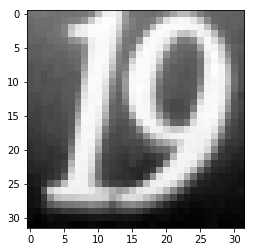

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


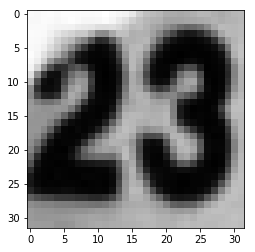

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


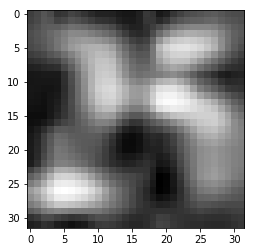

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


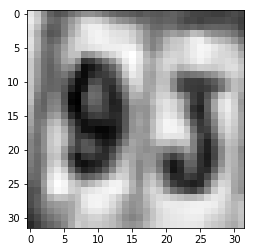

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


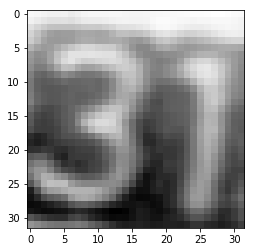

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


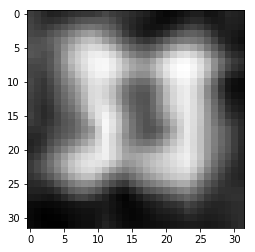

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


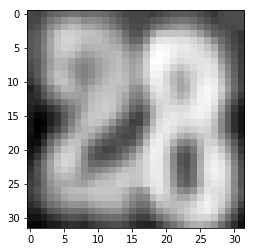

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


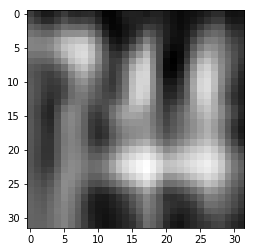

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


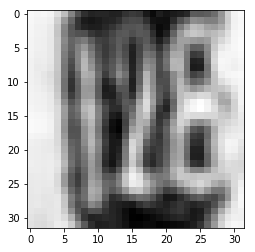

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


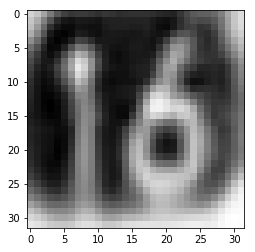

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


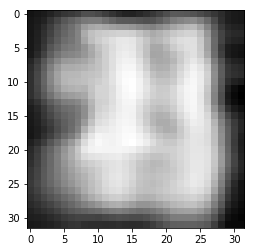

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


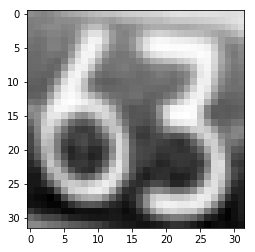

[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


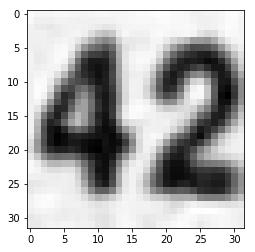

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


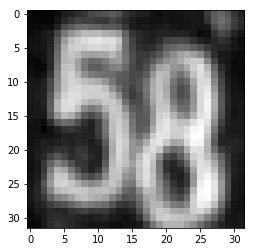

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


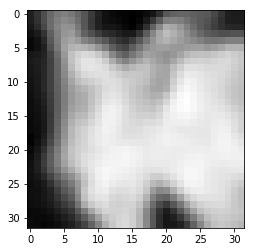

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


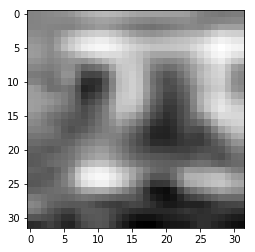

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


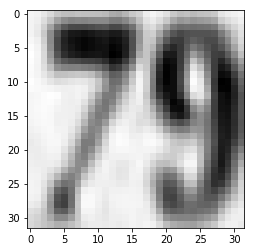

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


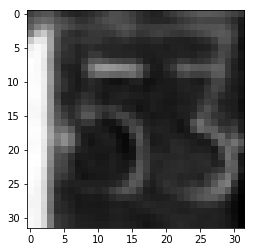

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


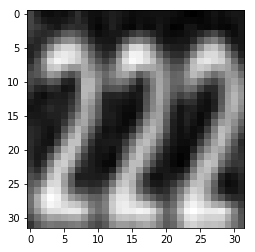

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


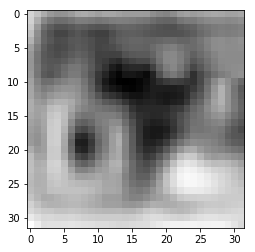

In [16]:
for idx in range(20):
    print(train_labels[idx])
    plt.imshow(train_dataset[idx, :, :, 0], cmap=plt.cm.Greys)
    plt.show()

In [18]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH = 16

STRIDE = 1
POOL_STRIDE = 2
POOL_KERNEL_SIZE = 2

NUM_HIDDEN = 256

NUM_STEPS = 10001

graph = tf.Graph()

with graph.as_default():
    
    tf_train_dataset = tf.placeholder(
        dtype=tf.float32,
        shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    )
    
    tf_train_labels = tf.placeholder(
        dtype=tf.float32,
        shape=(BATCH_SIZE * (MAX_DIGITS + 1), NUM_LABELS)
    )
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    tf_data = tf.placeholder(
        dtype=tf.float32,
        shape=(1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS),
        name='data'
    )
    
    loss_weights = tf.constant([10, 10, 5, 1, 1], dtype=tf.float32)
    
    keep_prob = tf.placeholder(
        dtype=tf.float32,
        name='keep_prob'
    )
    
    global_step = tf.Variable(0, trainable=False)
    initial_learning_rate = 0.05
    learning_rate = tf.train.exponential_decay(
        learning_rate=initial_learning_rate,
        global_step=global_step,
        decay_steps=50,
        decay_rate=0.96,
        staircase=True
    )
    
    l01_weights = tf.Variable(tf.truncated_normal(
        [7, 7, NUM_CHANNELS, DEPTH],
        stddev=0.1
    ))
    l01_biases = tf.Variable(tf.zeros([DEPTH]))
    
    l02_weights = tf.Variable(tf.truncated_normal(
        [PATCH_SIZE, PATCH_SIZE, DEPTH, DEPTH],
        stddev=0.1
    ))
    l02_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH]))

    li01_1_1x1_weights = tf.Variable(tf.truncated_normal(
        [1, 1, 16, 8],
        stddev=0.1
    ))
    li01_1_1x1_biases = tf.Variable(tf.constant(1.0, shape=[8]))
    
    li01_2_1x1_weights = tf.Variable(tf.truncated_normal(
        [1, 1, 16, 8],
        stddev=0.1
    ))
    li01_2_1x1_biases = tf.Variable(tf.constant(1.0, shape=[8]))

    li01_2_3x3_weights = tf.Variable(tf.truncated_normal(
        [3, 3, 8, 16],
        stddev=0.1
    ))
    li01_2_3x3_biases = tf.Variable(tf.constant(1.0, shape=[16]))
    
    li01_3_1x1_weights = tf.Variable(tf.truncated_normal(
        [1, 1, 16, 8],
        stddev=0.1
    ))
    li01_3_1x1_biases = tf.Variable(tf.constant(1.0, shape=[8]))

    li01_3_5x5_weights = tf.Variable(tf.truncated_normal(
        [5, 5, 8, 16],
        stddev=0.1
    ))
    li01_3_5x5_biases = tf.Variable(tf.constant(1.0, shape=[16]))

    li01_4_1x1_weights = tf.Variable(tf.truncated_normal(
        [1, 1, 16, 16],
        stddev=0.1
    ))
    li01_4_1x1_biases = tf.Variable(tf.constant(1.0, shape=[16]))
    
    l03_weights = tf.Variable(tf.truncated_normal(
        [IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 56, NUM_HIDDEN],
        stddev=0.1
    ))
    l03_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]))
    
    lc_d1_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_d1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    lc_d2_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_d2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    lc_d3_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_d3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    lc_d4_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_d4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    lc_d5_weights = tf.Variable(tf.truncated_normal(
        [NUM_HIDDEN, NUM_LABELS],
        stddev=0.1
    ))
    lc_d5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    def model(data):
        
        conv = tf.nn.conv2d(
            input=data,
            filter=l01_weights,
            strides=[1, STRIDE, STRIDE, 1],
            padding='SAME'
        )
        hidden = tf.nn.relu(conv + l01_biases)
        pool = tf.nn.max_pool(
            value=hidden,
            ksize=[1, POOL_KERNEL_SIZE, POOL_KERNEL_SIZE, 1],
            strides=[1, POOL_STRIDE, POOL_STRIDE, 1],
            padding='VALID'
        )
        
        conv = tf.nn.conv2d(
            input=pool,
            filter=l02_weights,
            strides=[1, STRIDE, STRIDE, 1],
            padding='SAME'
        )
        hidden = tf.nn.relu(conv + l02_biases)
        pool = tf.nn.max_pool(
            value=hidden,
            ksize=[1, POOL_KERNEL_SIZE, POOL_KERNEL_SIZE, 1],
            strides=[1, POOL_STRIDE, POOL_STRIDE, 1],
            padding='VALID'
        )        

        inception_01_1 = tf.nn.conv2d(
            input=pool,
            filter=li01_1_1x1_weights,
            strides=[1, 1, 1, 1],
            padding='SAME'
        ) + li01_1_1x1_biases
        
        inception_01_2_hidden = tf.nn.conv2d(
            input=pool,
            filter=li01_2_1x1_weights,
            strides=[1, 1, 1, 1],
            padding='SAME'
        ) + li01_2_1x1_biases
        inception_01_2 = tf.nn.conv2d(
            input=tf.nn.relu(inception_01_2_hidden),
            filter=li01_2_3x3_weights,
            strides=[1, 1, 1, 1],
            padding='SAME'
        ) + li01_2_3x3_biases

        inception_01_3_hidden = tf.nn.conv2d(
            input=pool,
            filter=li01_3_1x1_weights,
            strides=[1, 1, 1, 1],
            padding='SAME'
        ) + li01_3_1x1_biases
        inception_01_3 = tf.nn.conv2d(
            input=tf.nn.relu(inception_01_3_hidden),
            filter=li01_3_5x5_weights,
            strides=[1, 1, 1, 1],
            padding='SAME'
        ) + li01_3_5x5_biases
        
        inception_01_4_hidden = tf.nn.max_pool(
            value=pool,
            ksize=[1, POOL_KERNEL_SIZE, POOL_KERNEL_SIZE, 1],
            strides=[1, 1, 1, 1],
            padding='SAME'
        )
        inception_01_4 = tf.nn.conv2d(
            input=inception_01_4_hidden,
            filter=li01_4_1x1_weights,
            strides=[1, 1, 1, 1],
            padding='SAME'
        ) + li01_4_1x1_biases
        
        inception_01 = tf.nn.relu(
            tf.concat(
                values=[inception_01_1, inception_01_2, inception_01_3, inception_01_4],
                axis=3
            )
        )

        shape = inception_01.get_shape().as_list()
        reshape = tf.reshape(inception_01, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden = tf.nn.relu(tf.matmul(reshape, l03_weights) + l03_biases)
        dropout = tf.nn.dropout(hidden, keep_prob)
        return (
                tf.matmul(dropout, lc_d1_weights) + lc_d1_biases,
                tf.matmul(dropout, lc_d2_weights) + lc_d2_biases,
                tf.matmul(dropout, lc_d3_weights) + lc_d3_biases,
                tf.matmul(dropout, lc_d4_weights) + lc_d4_biases,
                tf.matmul(dropout, lc_d5_weights) + lc_d5_biases
        )
    
    logits_d1, logits_d2, logits_d3, logits_d4, logits_d5 = model(tf_train_dataset)
        
    labels_d1, labels_d2, labels_d3, labels_d4, labels_d5, _ = tf.split(
        tf_train_labels,
        num_or_size_splits=6,
        axis=0
    )
    
    loss_d1 = tf.nn.softmax_cross_entropy_with_logits(labels=labels_d1, logits=logits_d1)
    loss_d2 = tf.nn.softmax_cross_entropy_with_logits(labels=labels_d2, logits=logits_d2)
    loss_d3 = tf.nn.softmax_cross_entropy_with_logits(labels=labels_d3, logits=logits_d3)
    loss_d4 = tf.nn.softmax_cross_entropy_with_logits(labels=labels_d4, logits=logits_d4)
    loss_d5 = tf.nn.softmax_cross_entropy_with_logits(labels=labels_d5, logits=logits_d5)
 
    loss = tf.reduce_sum(loss_weights * tf.stack(
        (
            tf.reduce_mean(loss_d1),
            tf.reduce_mean(loss_d2),
            tf.reduce_mean(loss_d3),
            tf.reduce_mean(loss_d4),
            tf.reduce_mean(loss_d5)
        ),
        axis=0
    )) / tf.reduce_sum(loss_weights)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    train_prediction = tf.concat(
        (
            tf.nn.softmax(logits_d1),
            tf.nn.softmax(logits_d2),
            tf.nn.softmax(logits_d3),
            tf.nn.softmax(logits_d4),
            tf.nn.softmax(logits_d5)
        ),
        axis=0
    )
    
    v_logits_d1, v_logits_d2, v_logits_d3, v_logits_d4, v_logits_d5 = model(tf_valid_dataset)
    valid_prediction = tf.concat(
        (
            tf.nn.softmax(v_logits_d1),
            tf.nn.softmax(v_logits_d2),
            tf.nn.softmax(v_logits_d3),
            tf.nn.softmax(v_logits_d4),
            tf.nn.softmax(v_logits_d5)
        ),
        axis=0
    )
    
    t_logits_d1, t_logits_d2, t_logits_d3, t_logits_d4, t_logits_d5 = model(tf_test_dataset)
    test_prediction = tf.concat(
        (
            tf.nn.softmax(t_logits_d1),
            tf.nn.softmax(t_logits_d2),
            tf.nn.softmax(t_logits_d3),
            tf.nn.softmax(t_logits_d4),
            tf.nn.softmax(t_logits_d5)
        ),
        axis=0
    )
    
    logits_d1, logits_d2, logits_d3, logits_d4, logits_d5 = model(tf_data)
    prediction = tf.concat(
        (
            tf.nn.softmax(logits_d1),
            tf.nn.softmax(logits_d2),
            tf.nn.softmax(logits_d3),
            tf.nn.softmax(logits_d4),
            tf.nn.softmax(logits_d5)
        ),
        axis=0,
        name='prediction'
    )
    
with tf.Session(graph=graph) as session:
    
    saver = tf.train.Saver()
    
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(NUM_STEPS):
        
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset+BATCH_SIZE), :, :, :]
        batch_labels = reshape(train_labels[offset:(offset+BATCH_SIZE), :, :])
        
        feed_dict = {
            tf_train_dataset: batch_data,
            tf_train_labels: batch_labels,
            keep_prob: 1.0
        }
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 100 == 0):

            train_accuracies = accuracy(predictions, batch_labels)
            valid_accuracies = accuracy(valid_prediction.eval({keep_prob: 1.0}), reshape(valid_labels))
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracies: %s / Overall accuracy: %.1f%%' % (format_accuracy(train_accuracies[0]), train_accuracies[1]))
            print('Validation accuracies: %s / Overall accuracy: %.1f%%' % (format_accuracy(valid_accuracies[0]), valid_accuracies[1]))
            
    test_accuracies = accuracy(test_prediction.eval({keep_prob: 1.0}), reshape(test_labels))
    print('Test accuracies: %s / Overall accuracy: %.1f%%' % (format_accuracy(test_accuracies[0]), test_accuracies[1]))
    
    saver.save(session, 'svhn')


Initialized
Minibatch loss at step 0: 11.815453
Minibatch accuracies: ['0.0%', '7.8%', '0.0%', '0.0%', '0.0%'] / Overall accuracy: 1.6%
Validation accuracies: ['19.6%', '9.9%', '40.7%', '0.9%', '99.9%'] / Overall accuracy: 34.2%
Minibatch loss at step 100: 1.929122
Minibatch accuracies: ['21.9%', '9.4%', '64.1%', '95.3%', '100.0%'] / Overall accuracy: 58.1%
Validation accuracies: ['19.6%', '5.1%', '40.7%', '92.7%', '99.9%'] / Overall accuracy: 51.6%
Minibatch loss at step 200: 1.788102
Minibatch accuracies: ['28.1%', '20.3%', '71.9%', '98.4%', '100.0%'] / Overall accuracy: 63.7%
Validation accuracies: ['30.7%', '6.8%', '40.7%', '92.7%', '99.9%'] / Overall accuracy: 54.2%
Minibatch loss at step 300: 1.817054
Minibatch accuracies: ['32.8%', '23.4%', '64.1%', '96.9%', '100.0%'] / Overall accuracy: 63.4%
Validation accuracies: ['30.9%', '19.4%', '40.7%', '92.7%', '99.9%'] / Overall accuracy: 56.7%
Minibatch loss at step 400: 1.609047
Minibatch accuracies: ['40.6%', '26.6%', '70.3%', '95.3%

Minibatch loss at step 3600: 0.737136
Minibatch accuracies: ['76.6%', '71.9%', '90.6%', '98.4%', '100.0%'] / Overall accuracy: 87.5%
Validation accuracies: ['80.9%', '69.0%', '71.9%', '92.6%', '99.9%'] / Overall accuracy: 82.9%
Minibatch loss at step 3700: 0.767480
Minibatch accuracies: ['73.4%', '67.2%', '81.2%', '98.4%', '100.0%'] / Overall accuracy: 84.1%
Validation accuracies: ['81.1%', '68.6%', '71.8%', '92.6%', '99.9%'] / Overall accuracy: 82.8%
Minibatch loss at step 3800: 0.803202
Minibatch accuracies: ['75.0%', '68.8%', '75.0%', '95.3%', '100.0%'] / Overall accuracy: 82.8%
Validation accuracies: ['80.8%', '68.3%', '71.4%', '92.7%', '99.9%'] / Overall accuracy: 82.6%
Minibatch loss at step 3900: 0.807507
Minibatch accuracies: ['76.6%', '62.5%', '84.4%', '93.8%', '100.0%'] / Overall accuracy: 83.4%
Validation accuracies: ['80.8%', '68.5%', '72.0%', '92.6%', '99.9%'] / Overall accuracy: 82.8%
Minibatch loss at step 4000: 0.778439
Minibatch accuracies: ['82.8%', '68.8%', '79.7%', 

Minibatch loss at step 7200: 0.824740
Minibatch accuracies: ['76.6%', '60.9%', '81.2%', '96.9%', '100.0%'] / Overall accuracy: 83.1%
Validation accuracies: ['81.7%', '70.0%', '72.7%', '92.6%', '99.9%'] / Overall accuracy: 83.4%
Minibatch loss at step 7300: 0.829594
Minibatch accuracies: ['75.0%', '65.6%', '79.7%', '95.3%', '100.0%'] / Overall accuracy: 83.1%
Validation accuracies: ['81.7%', '70.1%', '72.8%', '92.6%', '99.9%'] / Overall accuracy: 83.4%
Minibatch loss at step 7400: 0.657125
Minibatch accuracies: ['81.2%', '76.6%', '81.2%', '93.8%', '100.0%'] / Overall accuracy: 86.6%
Validation accuracies: ['81.7%', '70.1%', '72.8%', '92.6%', '99.9%'] / Overall accuracy: 83.4%
Minibatch loss at step 7500: 0.643611
Minibatch accuracies: ['85.9%', '71.9%', '75.0%', '89.1%', '100.0%'] / Overall accuracy: 84.4%
Validation accuracies: ['81.8%', '70.2%', '72.9%', '92.6%', '99.9%'] / Overall accuracy: 83.5%
Minibatch loss at step 7600: 0.584592
Minibatch accuracies: ['87.5%', '79.7%', '78.1%', 